In [100]:
import os
import sys

sys.path.insert(1, os.path.join(sys.path[0], '..'))

import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *
from scipy.optimize import minimize
from scipy.linalg import lapack
from src.richards import picard_solver
from src.viz import plot_3d
from src.hydro import *
from src.cst import *

# Credits to https://stackoverflow.com/a/58719188/12337518
inds_cache = {}

def upper_triangular_to_symmetric(ut):
    n = ut.shape[0]
    try:
        inds = inds_cache[n]
    except KeyError:
        inds = np.tri(n, k=-1, dtype=bool)
        inds_cache[n] = inds
    ut[inds] = ut.T[inds]

# Faster than solving an LU system each time
def fast_positive_definite_inverse(m):
    cholesky, info = lapack.dpotrf(m)
    if info != 0:
        raise ValueError('dpotrf failed on input {}'.format(m))
    inv, info = lapack.dpotri(cholesky)
    if info != 0:
        raise ValueError('dpotri failed on input {}'.format(cholesky))
    upper_triangular_to_symmetric(inv)
    return inv

In [101]:
# Solving Richards equation and formatting solution as a dataset for GPR
z, t, h, thta = picard_solver(z_max=60, t_max=50)
noise_pct = 0.01

X = np.dstack(np.meshgrid(z, t)).reshape(-1, 2)
y = thta.T.flatten()
y += noise_pct * np.std(y) * np.random.randn(len(y))

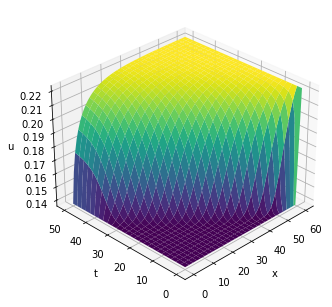

In [27]:
plot_3d(z, t, thta)

In [28]:
# Initializing GPR parameters
l_z = np.std(z)
l_t = np.std(t)
L = np.array([l_z, l_t])
sigma_s2 = np.var(thta) / 2
sigma_y2 = np.var(thta) / 2

In [102]:
# Setting up kernel, GPR, and fitting GPR
kernel = ConstantKernel(constant_value=sigma_s2, constant_value_bounds=(10e-8, 100)) * RBF(length_scale=L, length_scale_bounds=(0.1, 100)) + WhiteKernel(noise_level=sigma_y2, noise_level_bounds=(10e-8, 100))
gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
gpr.fit(X, y)

GaussianProcessRegressor(kernel=0.0253**2 * RBF(length_scale=[17.6, 14.7]) + WhiteKernel(noise_level=0.000638),
                         normalize_y=True)

In [30]:
def dkdx(i, X, X_star, gpr) :
    """
    Returns the first order kernel derivative dk(x, x*)/dx_i for a given Gaussian process

    Args:
        i (int) : dataset feature along which differentiation is performed
        X (n*m ndarray) : training set for the GPR.
        X_star (n'*m ndarray) : other dataset. Must have same number of features as X.
        gpr (GaussianProcessRegressor object) : Gaussian process used as basis for differentiation

    Returns:
        dk (n*n' ndarray) : first order derivative values dk(x, x*)/dx_i for every pair of points of X and X_star
    """
    kernel = gpr.kernel_

    noise = WhiteKernel(noise_level=kernel.get_params()['k2__noise_level'])
    K = kernel.__call__(X, X_star) - noise.__call__(X, X_star)

    l_i = kernel.get_params()['k1__k2__length_scale'][i]
    diff = np.subtract.outer(X[:, i], X_star[:, i])

    dk = K * diff / (l_i**2)

    return dk

def d2kdx2(i, X, X_star, gpr) :
    """
    Returns the second order kernel derivative d2k(x, x*)/dx_i2 for a given Gaussian process

    Args:
        i (int) : dataset feature along which differentiation is performed
        X (n*m ndarray) : training set for the GPR.
        X_star (n'*m ndarray) : other dataset. Must have same number of features as X.
        gpr (GaussianProcessRegressor object) : Gaussian process used as basis for differentiation

    Returns:
        d2k (n*n' ndarray) : second order derivative values d2k(x, x*)/dx_i2 for every pair of points of X and X_star
    """
    kernel = gpr.kernel_

    noise = WhiteKernel(noise_level=kernel.get_params()['k2__noise_level'])
    K = kernel.__call__(X, X_star) - noise.__call__(X, X_star)

    l_i = kernel.get_params()['k1__k2__length_scale'][i]
    diff = np.subtract.outer(X[:, i], X_star[:, i]) / (l_i**2)

    d2k = (K / (l_i**2)) * (diff**2 / (l_i**2) - 1)

    return d2k

def dydx(i, X_star, y_pred, Ksigma, gpr) :
    """
    Returns the first order derivative dy*/dx_i for a given Gaussian process

    Args:
        i (int) : dataset feature along which differentiation is performed
        X_star (ndarray) : new observations. Must have same number of features as the training set used for fitting gpr
        y_pred (1d ndarray) : mean prediction of gpr
        Ksigma (ndarray) : inverse GPR kernel matrix. Equal to (K + sigma_y**2 I)^(-1) with I the identity matrix and K the GPR's kernel matrix
        gpr (GaussianProcessRegressor object) : Gaussian process used as basis for differentiation

    Returns:
        dy_star (ndarray) : first order derivative values dy*(x*)/dx_i of the GPR's prediction for every point in X_star
    """
    X = gpr.X_train_
    y = gpr.y_train_
    
    Kdot = dkdx(i, X, X_star, gpr)

    dy_star = Kdot.T @ Ksigma @ (y - y_pred)

    return  dy_star

def d2ydx2(i, X_star, y_pred, Ksigma, gpr) :
    """
    Returns the second order derivative d2y*/dx_i2 for a given Gaussian process

    Args:
        i (int) : dataset feature along which differentiation is performed
        X_star (ndarray) : new observations. Must have same number of features as the training set used for fitting gpr
        y_pred (1d ndarray) : mean prediction of gpr
        Ksigma (ndarray) : inverse GPR kernel matrix. Equal to (K + sigma_y**2 I)^(-1) with I the identity matrix and K the GPR's kernel matrix
        gpr (GaussianProcessRegressor object) : Gaussian process used as basis for differentiation

    Returns:
        d2y_star (ndarray) : second order derivative values d2y*(x*)/dx_i2 of the GPR's prediction for every point in X_star
    """
    X = gpr.X_train_
    y = gpr.y_train_

    Kdotdot = d2kdx2(i, X, X_star, gpr)

    d2y_star = Kdotdot.T @ Ksigma @ (y - y_pred)

    return d2y_star

In [31]:
# S is big Theta in Rai and Tripathi's paper, theta is small theta
def dSdtheta(theta_r, theta_s) :
    return 1 / (theta_s - theta_r)

def dkdS(S, k_s, m) :
    S_factor = 1 - (1 - S**(1/m))**m
    return 2 * k_s * np.sqrt(S) * S_factor * ((1 - S**(1/m))**(m - 1) * (S**(1/m - 1))) + (k_s / 2) * (1 / np.sqrt(S)) * (S_factor**2)

def dSdh(S, h, alpha, m) :
    B0 = - alpha * m * np.sign(h) / (1 - m)
    return B0 * (S**((1 + m) / m)) * ((S**(-1/m) - 1)**m)

def dhdtheta(S, h, alpha, m, theta_r, theta_s) :
    return dSdtheta(theta_r, theta_s) / dSdh(S, h, alpha, m)

def d2hdzdtheta(dthetadz, h, S, alpha, m, theta_r, theta_s) :
    B0 = - alpha * m * np.sign(h) / (1 - m)
    return (1/B0) * dSdtheta(theta_r, theta_s) * dthetadz * (-((1 + m) / m) * S**(-(1 + 2 * m) / m) * ((S**(-1/m) - 1)**(-m)) + S**(-(2 + 2 * m) / m) * ((S**(-1/m) - 1)**(-m - 1)))

In [32]:
def term3(dthetadz, S, k_s, m, theta_r, theta_s) :
    return dkdS(S, k_s, m) * dSdtheta(theta_r, theta_s) * dthetadz

def term1(dthetadz, S, k_s, h, alpha, m, theta_r, theta_s) :
    return term3(dthetadz, S, k_s, m, theta_r, theta_s) * dhdtheta(S, h, alpha, m, theta_r, theta_s) * dthetadz

def term2(dthetadz, d2thetadz2, S, h, alpha, m, theta_r, theta_s) :
    return d2hdzdtheta(dthetadz,h, S, alpha, m, theta_r, theta_s) * dthetadz + dhdtheta(S, h, alpha, m, theta_r, theta_s) * d2thetadz2

def ssre(pde_param, dthetadt, dthetadz, d2thetadz2, K, S, k_s, h, theta_r, theta_s) :
    alpha, m = pde_param
    return np.sum((dthetadt - (term1(dthetadz, S, k_s, h, alpha, m, theta_r, theta_s) + K * term2(dthetadz, d2thetadz2, S, h, alpha, m, theta_r, theta_s) + term3(dthetadz, S, k_s, m, theta_r, theta_s)))**2)

In [55]:
thta_gp = gpr.predict(X)
Ksigma = fast_positive_definite_inverse(gpr.kernel_.__call__(X))

h_gp = np.vectorize(h_)(thta_gp, theta_r, theta_s, n, m, alpha)
s_gp = np.vectorize(S)(thta_gp, theta_r, theta_s)
K_gp = np.vectorize(k)(h_gp, s_gp, k_s, m)

dthetadt = dydx(1, X, thta_gp, Ksigma, gpr)
dthetadz = dydx(0, X, thta_gp, Ksigma, gpr)
d2thetadz2 = d2ydx2(0, X, thta_gp, Ksigma, gpr)

pde_param = np.array([alpha, m])
gpr_param = (dthetadt, dthetadz, d2thetadz2, K_gp, s_gp, k_s, h_gp, theta_r, theta_s)

epsilon = 10e-1
pde_param_0 = pde_param + epsilon * pde_param * np.random.randn(2)

In [97]:
alpha_gp, m_gp = minimize(fun=ssre, x0=np.array([0.03, 0.3]), args=gpr_param, method='Nelder-Mead').x
n_gp = 1 / (1 - m_gp)

In [98]:
m_gp

1.000000085384942

In [89]:
def metropolis_hastings(x_0, log_likelihood, step=1, n_iter=100) :
    dim = len(x_0)
    walk = np.empty((n_iter + 1, dim))
    walk[0] = x_0

    for i in range(n_iter) :
        x_i = walk[i]
        lik_iminus1 = log_likelihood(x_i)

        x_iplus1 = x_i + step*np.random.randn(dim)
        lik_i = log_likelihood(x_iplus1)

        if lik_i > lik_iminus1 :
            walk[i+1] = x_iplus1
        
        else : 
            u = np.random.uniform(0, 1)
            if u < np.exp(lik_i - lik_iminus1) :
                walk[i+1] = x_iplus1
            else :
                walk[i+1] = x_i
    
    return walk

In [92]:
ssre_log_likelihood = (lambda alpha_m : -ssre((alpha_m[0], alpha_m[1]), dthetadt, dthetadz, d2thetadz2, K_gp, s_gp, k_s, h_gp, theta_r, theta_s))

mcmc_epsilon = 10e-3
mcmc_n_iter = 500
pde_walk = metropolis_hastings(np.array([0.051, 0.3]), ssre_log_likelihood, step=mcmc_epsilon*pde_param, n_iter=mcmc_n_iter)

alpha_mcmc, m_mcmc = pde_walk[len(pde_walk) - 1][0], pde_walk[len(pde_walk) - 1][1]

Text(0, 0.5, 'm')

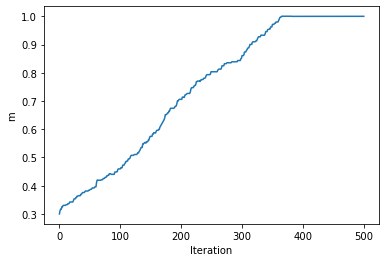

In [93]:
plt.plot(np.arange(mcmc_n_iter + 1), pde_walk[:, 1])
plt.xlabel("Iteration")
plt.ylabel("m")

Text(0, 0.5, 'alpha')

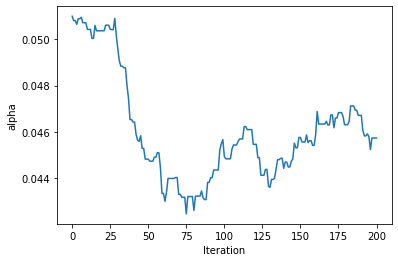

In [83]:
plt.plot(np.arange(mcmc_n_iter + 1), pde_walk[:, 0])
plt.xlabel("Iteration")
plt.ylabel("alpha")

In [86]:
plt.plot(pde_param[:, 0], pde_param[:, 1])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
def MALA(x_0, log_likelihood, dlog_pi, step, n_iter=100) :
    dim = len(x_0)
    walk = np.empty((n_iter + 1, dim))
    walk[0] = x_0
    accepted = 0

    for i in range(n_iter) :
        x_i = walk[i]
        lik_iminus1 = log_likelihood(x_i)

        x_iplus1 = x_i + step * dlog_pi(x_i) + np.sqrt(2 * step)*np.random.randn(dim)
        lik_i = log_likelihood(x_iplus1)

        if lik_i > lik_iminus1 :
            walk[i+1] = x_iplus1
            accepted += 1
        
        else : 
            u = np.random.uniform(0, 1)
            if u < np.exp(lik_i - lik_iminus1) :
                walk[i+1] = x_iplus1
                accepted += 1
            else :
                walk[i+1] = x_i
    
    return walk, accepted / n_iter

-6.351326785722318e-06